# Greenhouse Environmental Data Visualization

This notebook demonstrates the greenhouse mapping tool for visualizing environmental sensor data with high-resolution spatial interpolation.

## Features:
- 1cm resolution interpolated maps
- Temperature, Humidity, Pressure, and Gas Resistance visualization
- Statistical metrics (R², RMSE, etc.)
- TimescaleDB integration
- GeoPandas-based spatial analysis

## 1. Import Required Libraries

In [1]:
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Import our custom modules
from greenhouse_mapper import GreenhouseMapper
from db_connector import TimescaleDBConnector

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"GeoPandas version: {gpd.__version__}")

Libraries imported successfully!
NumPy version: 2.0.2
Pandas version: 2.3.3
GeoPandas version: 1.0.1


## 2. Create Sample Sensor Data

We'll use the provided 8-sensor test data representing a single moment in time.

In [2]:
# Test data from 8 sensors
sensor_data = [
    {'temperature': 23.90, 'humidity': 48.43, 'pressure': 1009.11, 'resistance': 78424.00},
    {'temperature': 23.92, 'humidity': 48.44, 'pressure': 1009.15, 'resistance': 78773.00},
    {'temperature': 23.91, 'humidity': 48.44, 'pressure': 1009.11, 'resistance': 78773.00},
    {'temperature': 23.93, 'humidity': 48.44, 'pressure': 1009.11, 'resistance': 78703.00},
    {'temperature': 23.92, 'humidity': 48.45, 'pressure': 1009.11, 'resistance': 78493.00},
    {'temperature': 23.86, 'humidity': 48.46, 'pressure': 1009.13, 'resistance': 78843.00},
    {'temperature': 23.93, 'humidity': 48.46, 'pressure': 1009.13, 'resistance': 78354.00},
    {'temperature': 23.92, 'humidity': 48.47, 'pressure': 1009.11, 'resistance': 78633.00},
]

# Convert to DataFrame for easy viewing
df_sensors = pd.DataFrame(sensor_data)
df_sensors.index.name = 'Sensor ID'
print(f"Number of sensors: {len(sensor_data)}")
print("\nSensor Data:")
df_sensors

Number of sensors: 8

Sensor Data:


,temperature,humidity,pressure,resistance
Sensor ID,,,,
0,23.90,48.43,1009.11,78424.0
1,23.92,48.44,1009.15,78773.0
2,23.91,48.44,1009.11,78773.0
3,23.93,48.44,1009.11,78703.0
4,23.92,48.45,1009.11,78493.0
5,23.86,48.46,1009.13,78843.0
6,23.93,48.46,1009.13,78354.0
7,23.92,48.47,1009.11,78633.0


## 3. Initialize the GreenhouseMapper

Create a mapper for a 4ft x 4ft (121.92cm x 121.92cm) greenhouse floor with 1cm resolution.

In [3]:
# Initialize mapper with 4ft x 4ft greenhouse (121.92 cm x 121.92 cm) at 1cm resolution
mapper = GreenhouseMapper(
    width_cm=121.92,
    height_cm=121.92,
    resolution_cm=1.0
)

print(f"Greenhouse dimensions: {mapper.width_cm} cm x {mapper.height_cm} cm")
print(f"Grid resolution: {mapper.resolution_cm} cm")
print(f"Grid shape: {mapper.x_grid.shape}")
print(f"Total grid points: {mapper.x_grid.size:,}")

Greenhouse dimensions: 121.92 cm x 121.92 cm
Grid resolution: 1.0 cm
Grid shape: (123, 123)
Total grid points: 15,129


## 4. Define Sensor Positions

Position the 8 sensors across the greenhouse floor. We'll use an evenly distributed grid pattern.

Sensor Positions (auto-generated):
   sensor_id       x       y  temperature  humidity
0          0   10.00   10.00        23.90     48.43
1          1   60.96   10.00        23.92     48.44
2          2  111.92   10.00        23.91     48.44
3          3   10.00   60.96        23.93     48.44
4          4   60.96   60.96        23.92     48.45
5          5  111.92   60.96        23.86     48.46
6          6   10.00  111.92        23.93     48.46
7          7   60.96  111.92        23.92     48.47


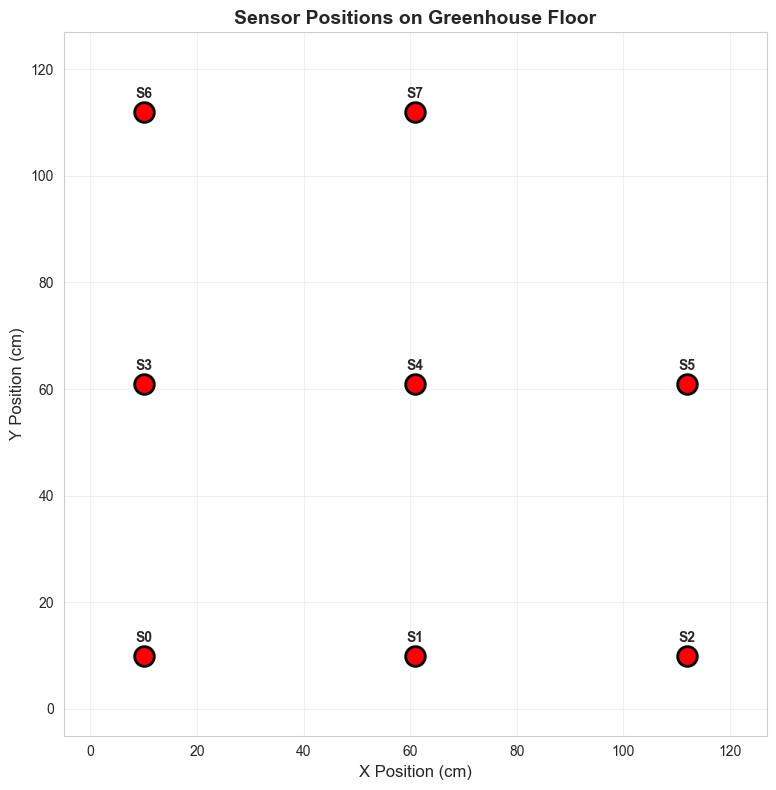

In [4]:
# Option 1: Let the mapper auto-position sensors (evenly distributed grid)
mapper.set_sensor_data(sensor_data)

# Display sensor positions
print("Sensor Positions (auto-generated):")
print(mapper.sensors[['sensor_id', 'x', 'y', 'temperature', 'humidity']].to_string())

# Visualize sensor positions
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(mapper.sensors['x'], mapper.sensors['y'], 
          c='red', s=200, marker='o', edgecolors='black', linewidths=2, zorder=5)

# Add sensor labels
for idx, row in mapper.sensors.iterrows():
    ax.annotate(f"S{int(row['sensor_id'])}", 
               (row['x'], row['y']), 
               textcoords="offset points", 
               xytext=(0, 10), 
               ha='center',
               fontsize=10,
               fontweight='bold')

ax.set_xlim(-5, mapper.width_cm + 5)
ax.set_ylim(-5, mapper.height_cm + 5)
ax.set_xlabel('X Position (cm)', fontsize=12)
ax.set_ylabel('Y Position (cm)', fontsize=12)
ax.set_title('Sensor Positions on Greenhouse Floor', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## 5. Generate Interpolated Maps for Each Parameter

Now let's create high-resolution interpolated maps for all environmental parameters.

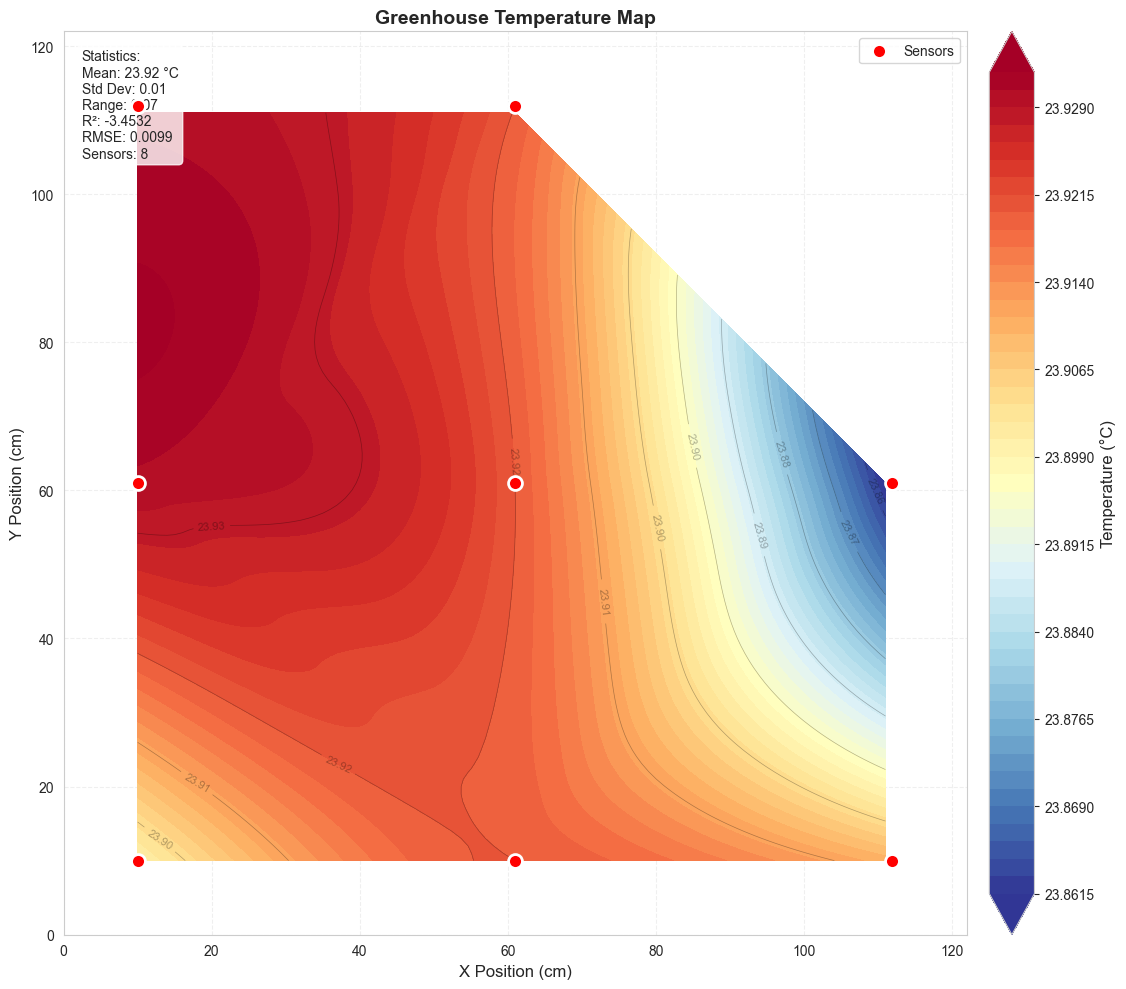


Temperature Statistics:
  mean: 23.91503874624214
  std: 0.014443920438311159
  min: 23.861343245396142
  max: 23.93223646218571
  range: 0.0708932167895675
  sensor_mean: 23.91125
  sensor_std: 0.021469455046647545
  r_squared: -3.453182628256263
  rmse: 0.009947844689238514
  num_sensors: 8


In [5]:
# Plot Temperature Map
fig_temp = mapper.plot_map('temperature', 
                           cmap='RdYlBu_r',  # Red-Yellow-Blue reversed
                           figsize=(12, 10),
                           show_sensors=True,
                           show_stats=True)
plt.show()

# Display temperature statistics
print("\nTemperature Statistics:")
temp_stats = mapper.get_statistics('temperature')
for key, value in temp_stats.items():
    print(f"  {key}: {value}")

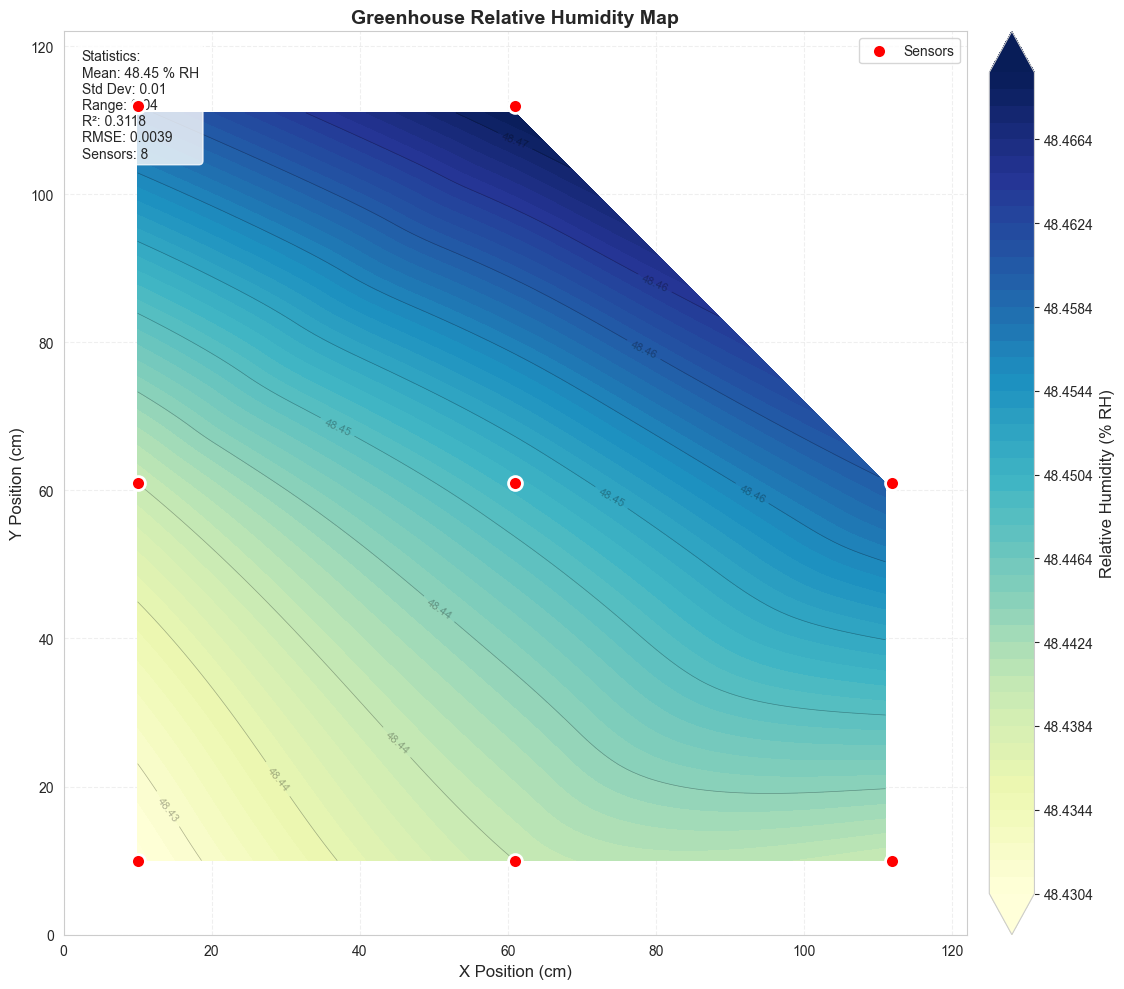

In [6]:
# Plot Humidity Map
fig_humidity = mapper.plot_map('humidity', 
                              cmap='YlGnBu',  # Yellow-Green-Blue
                              figsize=(12, 10),
                              show_sensors=True,
                              show_stats=True)
plt.show()

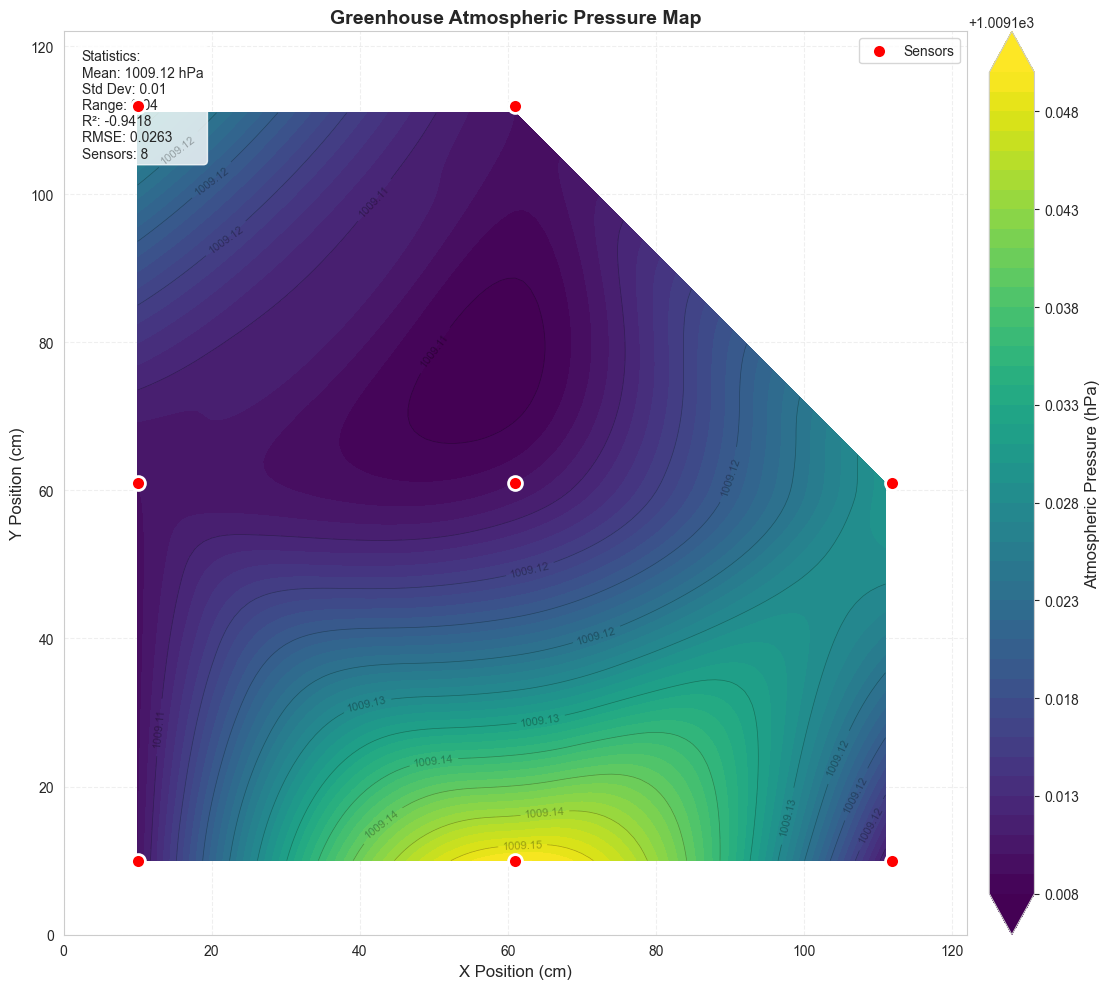

In [7]:
# Plot Pressure Map
fig_pressure = mapper.plot_map('pressure', 
                              cmap='viridis',
                              figsize=(12, 10),
                              show_sensors=True,
                              show_stats=True)
plt.show()

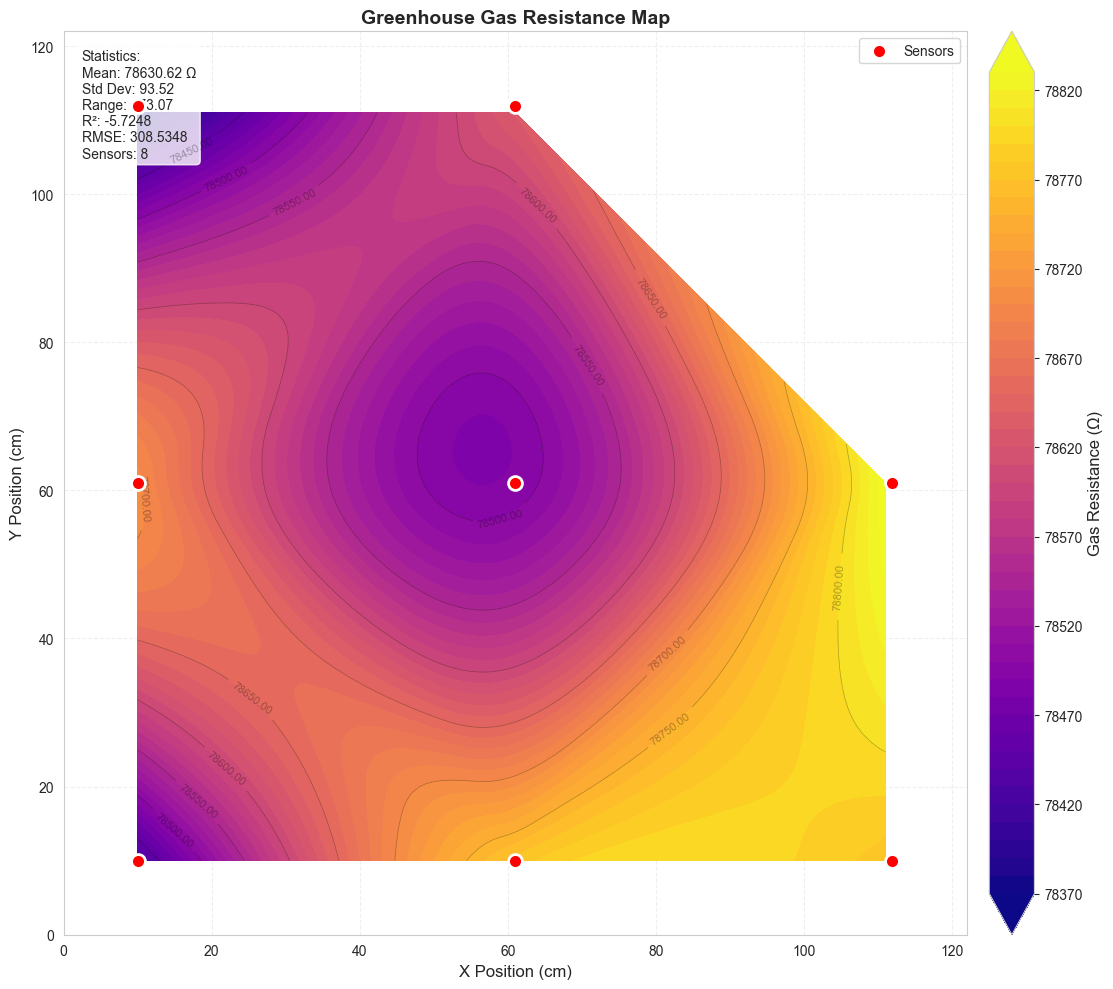

In [8]:
# Plot Gas Resistance Map
fig_resistance = mapper.plot_map('resistance', 
                                cmap='plasma',
                                figsize=(12, 10),
                                show_sensors=True,
                                show_stats=True)
plt.show()

## 6. Create Combined 2x2 Grid Visualization

Display all four environmental parameters in a single comprehensive view.

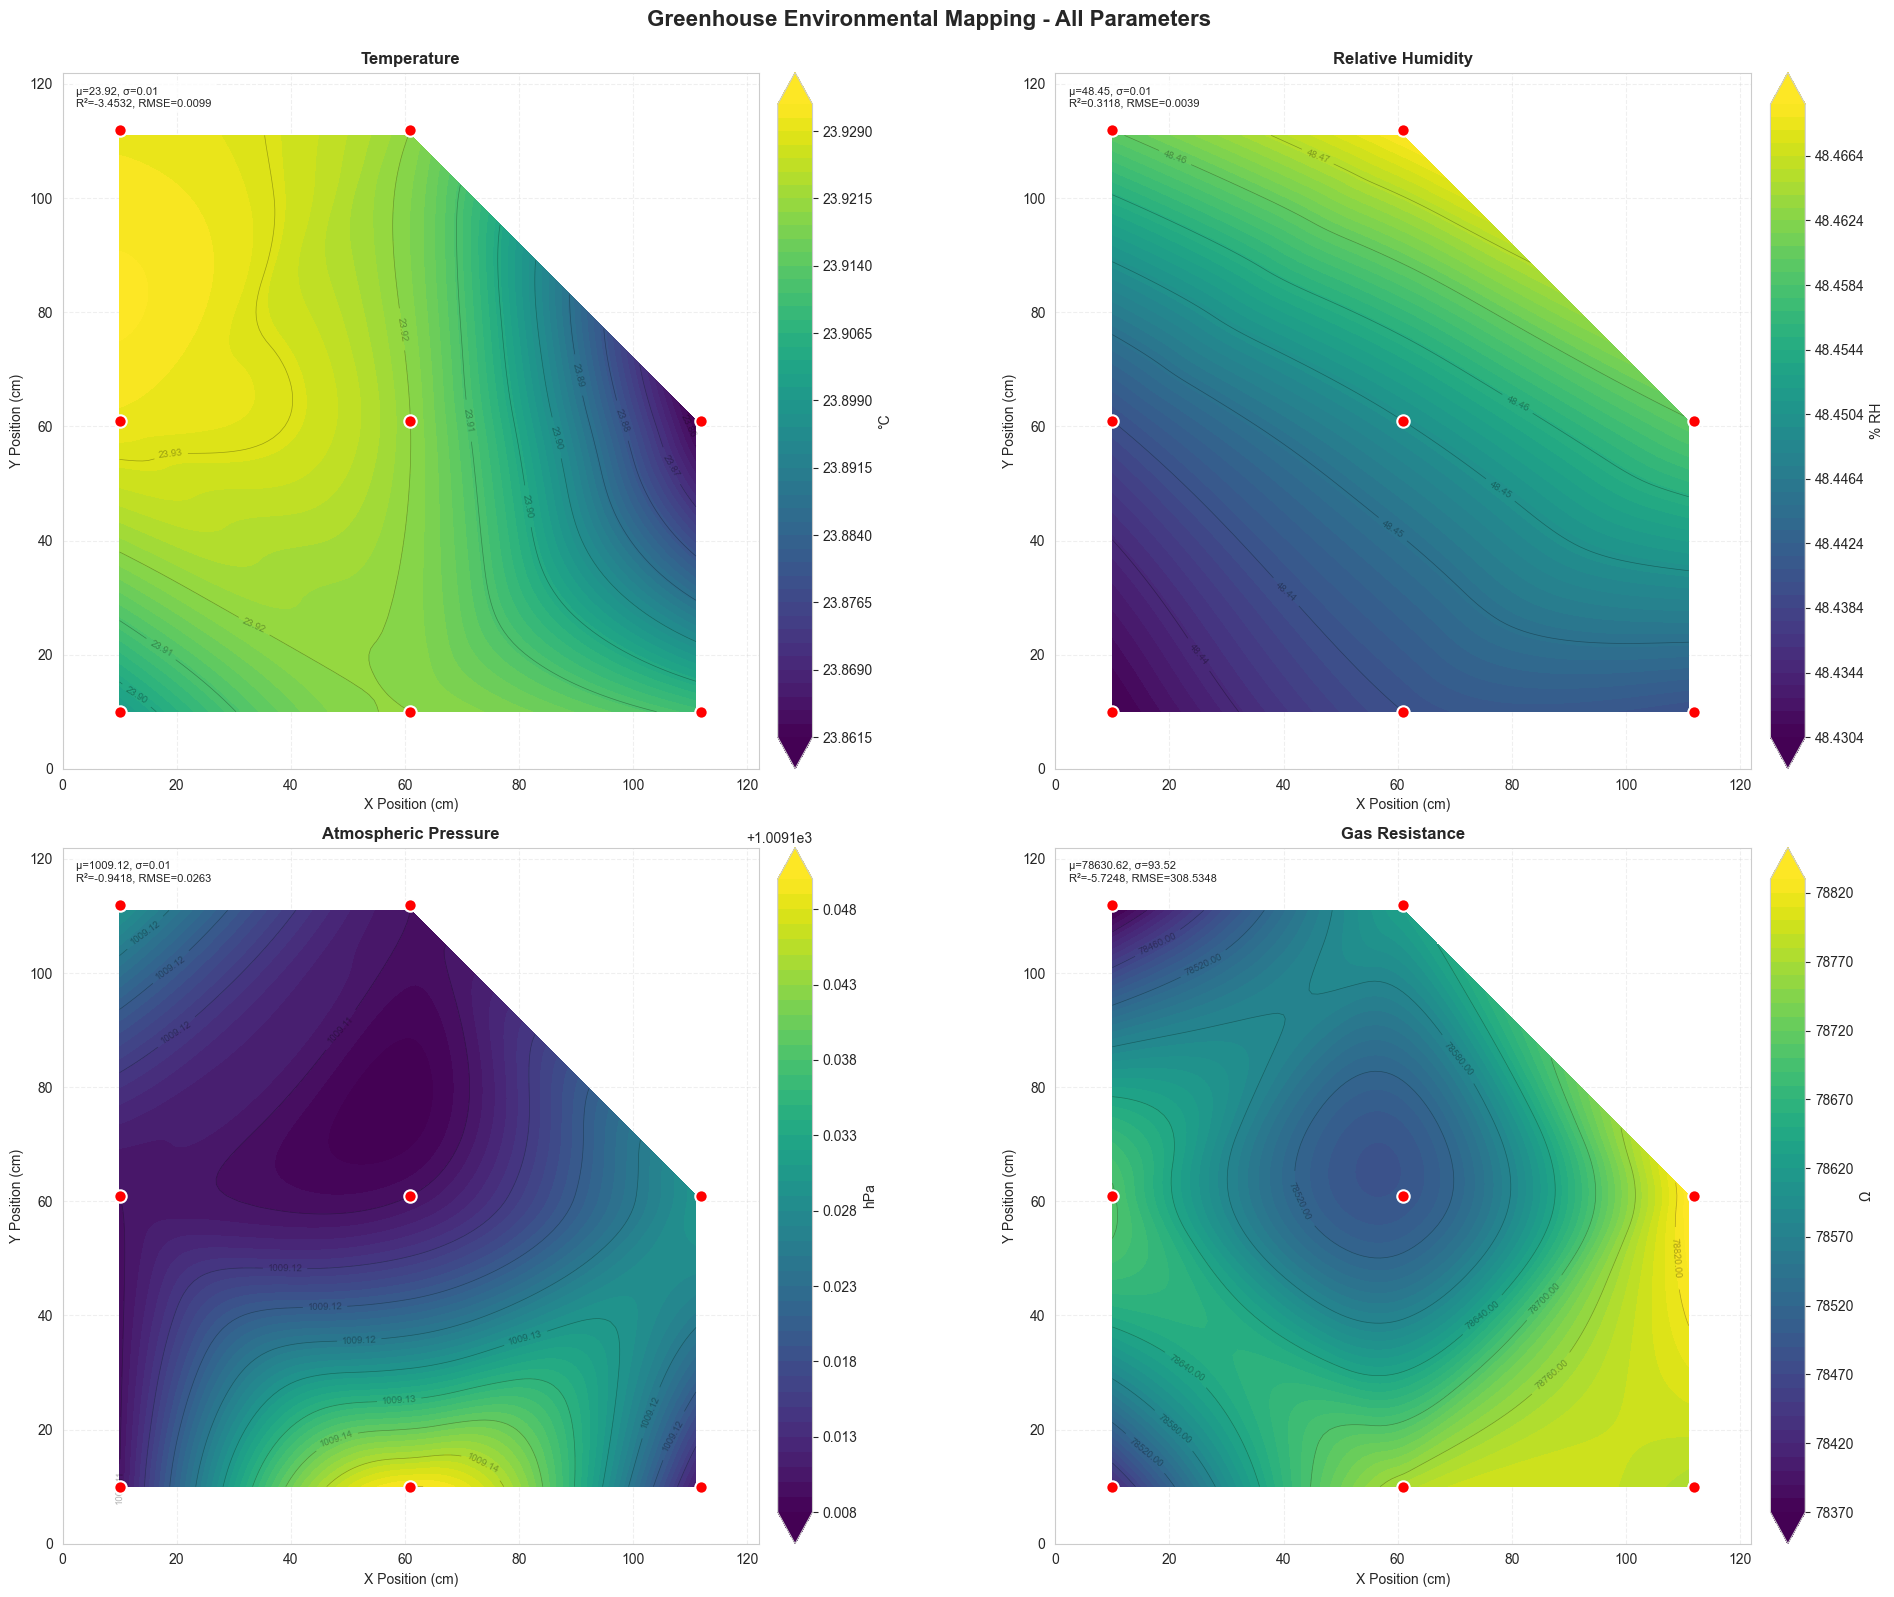

In [9]:
# Create comprehensive 2x2 visualization
fig_all = mapper.plot_all_parameters(figsize=(20, 16), cmap='viridis')
plt.show()

## 7. View Statistical Summary

Examine the interpolation quality and statistical metrics for all parameters.

In [10]:
# Get all statistics
all_stats = mapper.get_statistics()

# Create a summary DataFrame
summary_data = []
for param, stats in all_stats.items():
    summary_data.append({
        'Parameter': param.capitalize(),
        'Mean': f"{stats['mean']:.4f}",
        'Std Dev': f"{stats['std']:.4f}",
        'Range': f"{stats['range']:.4f}",
        'R²': f"{stats['r_squared']:.4f}",
        'RMSE': f"{stats['rmse']:.4f}",
        'Sensors': stats['num_sensors']
    })

df_summary = pd.DataFrame(summary_data)
print("Statistical Summary of Interpolated Maps:")
print("=" * 80)
print(df_summary.to_string(index=False))
print("=" * 80)
print("\nNotes:")
print("- R² (R-squared): Measures interpolation accuracy via leave-one-out cross-validation")
print("- RMSE: Root Mean Square Error of the interpolation")
print("- Higher R² values (closer to 1.0) indicate better interpolation quality")

Statistical Summary of Interpolated Maps:
  Parameter       Mean Std Dev    Range      R²     RMSE  Sensors
Temperature    23.9150  0.0144   0.0709 -3.4532   0.0099        8
   Humidity    48.4490  0.0086   0.0396  0.3118   0.0039        8
   Pressure  1009.1197  0.0100   0.0427 -0.9418   0.0263        8
 Resistance 78630.6163 93.5206 473.0683 -5.7248 308.5348        8

Notes:
- R² (R-squared): Measures interpolation accuracy via leave-one-out cross-validation
- RMSE: Root Mean Square Error of the interpolation
- Higher R² values (closer to 1.0) indicate better interpolation quality


## 8. TimescaleDB Integration (Optional)

Connect to TimescaleDB to query real sensor data from your greenhouse monitoring system.

**Note:** This section requires a running TimescaleDB instance. Update the connection parameters below.

In [11]:
# Example: Connect to TimescaleDB
# Uncomment and modify the connection parameters for your database

# db = TimescaleDBConnector(
#     host='localhost',
#     port=5432,
#     database='greenhouse',
#     user='postgres',
#     password='your_password'
# )

# Try to connect
# try:
#     db.connect()
#     print("Connected to TimescaleDB successfully!")
# except Exception as e:
#     print(f"Could not connect to database: {e}")
#     print("Using test data instead...")

print("Database connection section - update credentials to use real data")

Database connection section - update credentials to use real data


### Query Latest Sensor Readings from Database

Example of how to query the most recent readings from all sensors.

In [12]:
# Example: Query latest readings
# Uncomment when database is available

# df_latest = db.query_latest_readings()
# print("Latest sensor readings:")
# print(df_latest)

# # Get sensor positions (if you have a sensor_positions table)
# df_positions = db.get_sensor_positions()
# print("\nSensor positions:")
# print(df_positions)

# # Prepare data for mapper
# sensor_data_db, sensor_positions_db = db.prepare_data_for_mapper(df_latest, df_positions)

# # Create a new mapper with database data
# mapper_db = GreenhouseMapper(width_cm=121.92, height_cm=121.92, resolution_cm=1.0)
# mapper_db.set_sensor_data(sensor_data_db, sensor_positions_db)

# # Create visualization
# fig = mapper_db.plot_all_parameters(figsize=(20, 16))
# plt.show()

print("Database query example - uncomment to use with real database")

Database query example - uncomment to use with real database


### Query Time-Averaged Data

Example of querying time-averaged sensor data over a specific period.

In [13]:
# Example: Query time-averaged data for the last hour in 5-minute intervals
# Uncomment when database is available

# from datetime import datetime, timedelta

# end_time = datetime.now()
# start_time = end_time - timedelta(hours=1)

# df_averaged = db.query_time_averaged(
#     start_time=start_time,
#     end_time=end_time,
#     interval='5 minutes'
# )

# print(f"Time-averaged data from {start_time} to {end_time}:")
# print(df_averaged.head(20))

# # You can create visualizations for specific time buckets
# # For example, get the most recent time bucket
# if not df_averaged.empty:
#     latest_bucket = df_averaged.groupby('timestamp').first().reset_index().iloc[-1]
#     print(f"\nMost recent time bucket: {latest_bucket['timestamp']}")

print("Time-averaged query example - uncomment to use with real database")

Time-averaged query example - uncomment to use with real database


## 9. Export Data

You can export the interpolated data to CSV or other formats for further analysis.

In [14]:
# Export temperature data to CSV
# mapper.export_interpolated_data('temperature', 'temperature_map.csv', format='csv')
# print("Temperature data exported to temperature_map.csv")

# You can export any parameter
# mapper.export_interpolated_data('humidity', 'humidity_map.csv', format='csv')
# mapper.export_interpolated_data('pressure', 'pressure_map.csv', format='csv')
# mapper.export_interpolated_data('resistance', 'resistance_map.csv', format='csv')

print("Export example - uncomment to save interpolated data to CSV files")

Export example - uncomment to save interpolated data to CSV files


## 10. Advanced: Custom Sensor Positions

You can manually specify exact sensor positions if needed.

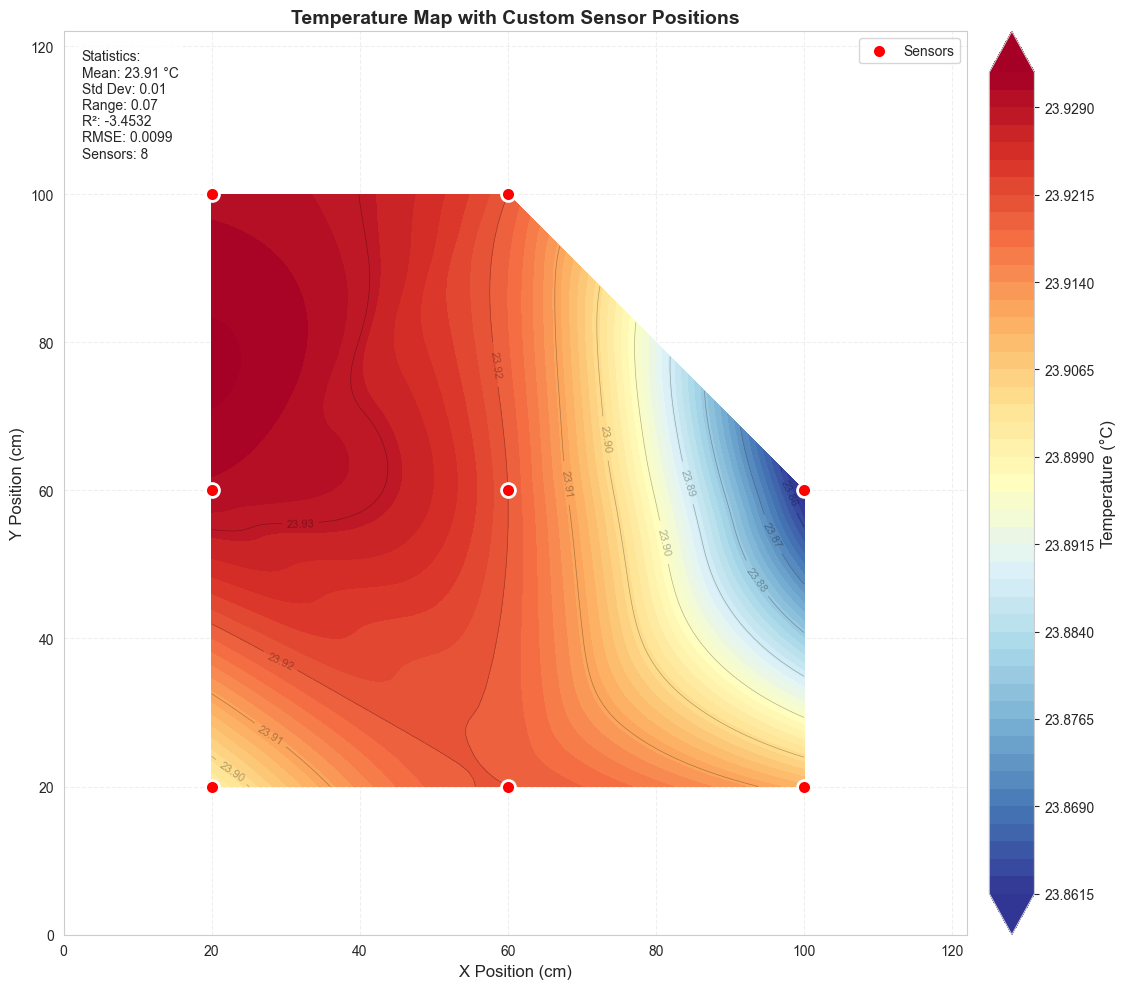


Custom sensor positions:
   sensor_id    x    y
0          0   20   20
1          1   60   20
2          2  100   20
3          3   20   60
4          4   60   60
5          5  100   60
6          6   20  100
7          7   60  100


In [15]:
# Example: Specify exact sensor positions (x, y in cm)
custom_positions = [
    (20, 20),    # Sensor 0
    (60, 20),    # Sensor 1
    (100, 20),   # Sensor 2
    (20, 60),    # Sensor 3
    (60, 60),    # Sensor 4
    (100, 60),   # Sensor 5
    (20, 100),   # Sensor 6
    (60, 100),   # Sensor 7
]

# Create a new mapper with custom positions
mapper_custom = GreenhouseMapper(width_cm=121.92, height_cm=121.92, resolution_cm=1.0)
mapper_custom.set_sensor_data(sensor_data, custom_positions)

# Visualize with custom positions
fig_custom = mapper_custom.plot_map('temperature', 
                                   cmap='RdYlBu_r',
                                   figsize=(12, 10),
                                   show_sensors=True,
                                   show_stats=True,
                                   title='Temperature Map with Custom Sensor Positions')
plt.show()

print("\nCustom sensor positions:")
print(mapper_custom.sensors[['sensor_id', 'x', 'y']].to_string())

## Summary

This notebook demonstrated the Greenhouse Environmental Data Visualization Tool with the following capabilities:

### Key Features:
1. **High-Resolution Mapping**: 1cm resolution interpolation across a 4ft x 4ft greenhouse floor
2. **Multiple Parameters**: Temperature, Humidity, Pressure, and Gas Resistance visualization
3. **Statistical Analysis**: R², RMSE, and other quality metrics for interpolation validation
4. **Flexible Sensor Placement**: Auto-positioning or custom sensor locations
5. **Database Integration**: TimescaleDB connector for querying time-series data
6. **Export Capabilities**: Save interpolated data to CSV for further analysis

### Next Steps:
- Connect to your TimescaleDB instance with real sensor data
- Create a `sensor_positions` table in your database for persistent sensor locations
- Schedule automated visualizations for monitoring trends over time
- Experiment with different interpolation methods (linear, cubic, RBF)
- Adjust grid resolution based on your needs (finer or coarser)

---

## 11. Plant Biomass Mapping Example

This section demonstrates mapping fresh biomass across plants when only some plants have environmental sensors. This is a realistic scenario where you have 12-15 total plants, but only 6-8 have measurement devices.

In [16]:
# Import the PlantMapper class
from plant_mapper import PlantMapper
import numpy as np

print("PlantMapper imported successfully!")

PlantMapper imported successfully!


### Create Plant Layout - Microclimate Study

Non-uniform distribution across the full 4×4 foot greenhouse to measure how microclimate influences spinach growth:
- **Total plants**: 16 (spread across 80% of greenhouse area)
- **Plants with sensors**: 7 (measuring environmental conditions)
- **Plants without sensors**: 9 (biomass only)
- **All plants**: Have fresh biomass measurements
- **Pot size**: 15.0 cm × 16.0 cm (5.9" × 6.3")
- **Spacing**: Non-uniform, strategically placed to sample different microclimates
- **Zones**: Bottom (cooler), Center (warmer), Top (warmest), Edges (variable airflow)

In [17]:
# Define plant positions - non-uniform distribution for microclimate sampling
# Spread across full 4×4 ft greenhouse to measure environmental gradients
# Strategic placement: corners, edges, center - optimized for spinach growth study
plant_positions = [
    ( 18,  18),    # Plant  0 - bottom-left corner
    ( 38,  25),    # Plant  1 - bottom-left area
    ( 25,  45),    # Plant  2 - left edge
    ( 88,  22),    # Plant  3 - bottom-right
    (108,  38),    # Plant  4 - right edge
    ( 95,  55),    # Plant  5 - right-center
    ( 42,  62),    # Plant  6 - center-left
    ( 65,  68),    # Plant  7 - center
    ( 85,  78),    # Plant  8 - center-right
    ( 15,  80),    # Plant  9 - left edge, upper
    ( 35,  92),    # Plant 10 - upper-left
    ( 22, 108),    # Plant 11 - top-left corner
    ( 58,  95),    # Plant 12 - upper-center
    ( 75, 100),    # Plant 13 - upper-right interior
    ( 95, 105),    # Plant 14 - upper-right
    (112, 115),    # Plant 15 - top-right corner
]

# Indicate which plants have sensors
# IMPROVED DISTRIBUTION: Better left-right balance, covers all zones
# Sensors measure: temperature, humidity, pressure, gas resistance
# Non-sensors measure: biomass only
has_sensor = [
    True,   # P0  - SENSOR (bottom-left corner)
    False,  # P1  - biomass only
    False,  # P2  - biomass only
    True,   # P3  - SENSOR (bottom-right)
    False,  # P4  - biomass only
    True,   # P5  - SENSOR (right-center)
    False,  # P6  - biomass only
    True,   # P7  - SENSOR (center)
    False,  # P8  - biomass only
    False,  # P9  - biomass only
    True,   # P10 - SENSOR (upper-left)
    False,  # P11 - biomass only
    True,   # P12 - SENSOR (upper-center)
    False,  # P13 - biomass only
    True,   # P14 - SENSOR (upper-right)
    False,  # P15 - biomass only
]

print(f"Microclimate Sampling Layout:")
print(f"  Total plants: {len(plant_positions)}")
print(f"  Plants with sensors: {sum(has_sensor)}")
print(f"  Plants without sensors: {len(has_sensor) - sum(has_sensor)}")
print(f"  Sensor coverage: {100*sum(has_sensor)/len(has_sensor):.0f}%")

# Verify sensor distribution
sensor_plants = [i for i, has_sens in enumerate(has_sensor) if has_sens]
print(f"\n✓ Sensors at plants: {sensor_plants}")

# Spatial coverage
xs = [x for x, y in plant_positions]
ys = [y for x, y in plant_positions]
sensor_xs = [plant_positions[i][0] for i in sensor_plants]
sensor_ys = [plant_positions[i][1] for i in sensor_plants]

print(f"\nSpatial Distribution:")
print(f"  All plants:  X={min(xs)}-{max(xs)} cm, Y={min(ys)}-{max(ys)} cm")
print(f"  Sensors:     X={min(sensor_xs)}-{max(sensor_xs)} cm, Y={min(sensor_ys)}-{max(sensor_ys)} cm")
print(f"  Sensor span: {max(sensor_xs)-min(sensor_xs)} cm (X) × {max(sensor_ys)-min(sensor_ys)} cm (Y)")

# Zone distribution
zones = {
    'Bottom-Left': [0,1,2], 'Bottom-Right': [3,4,5],
    'Center': [6,7,8], 'Upper-Left': [9,10,11], 'Upper-Right': [12,13,14,15]
}
print(f"\nSensor Distribution by Zone:")
for zone, plants in zones.items():
    zone_sensors = [p for p in plants if has_sensor[p]]
    print(f"  {zone:15} {len(zone_sensors)}/{len(plants)} sensors: {zone_sensors if zone_sensors else 'none'}")

Microclimate Sampling Layout:
  Total plants: 16
  Plants with sensors: 7
  Plants without sensors: 9
  Sensor coverage: 44%

✓ Sensors at plants: [0, 3, 5, 7, 10, 12, 14]

Spatial Distribution:
  All plants:  X=15-112 cm, Y=18-115 cm
  Sensors:     X=18-95 cm, Y=18-105 cm
  Sensor span: 77 cm (X) × 87 cm (Y)

Sensor Distribution by Zone:
  Bottom-Left     1/3 sensors: [0]
  Bottom-Right    2/3 sensors: [3, 5]
  Center          1/3 sensors: [7]
  Upper-Left      1/3 sensors: [10]
  Upper-Right     2/4 sensors: [12, 14]


### Generate Plant Data

Create realistic plant data with:
- **Fresh biomass**: All plants (20-45g range, with some spatial variation)
- **Environmental data**: Only for plants with sensors (using your BME680 test data)

In [18]:
# Environmental data from your BME680 sensors (for plants with sensors)
env_readings = [
    {'temperature': 23.90, 'humidity': 48.43, 'pressure': 1009.11, 'resistance': 78424.00},
    {'temperature': 23.92, 'humidity': 48.44, 'pressure': 1009.15, 'resistance': 78773.00},
    {'temperature': 23.91, 'humidity': 48.44, 'pressure': 1009.11, 'resistance': 78773.00},
    {'temperature': 23.93, 'humidity': 48.44, 'pressure': 1009.11, 'resistance': 78703.00},
    {'temperature': 23.92, 'humidity': 48.45, 'pressure': 1009.11, 'resistance': 78493.00},
    {'temperature': 23.86, 'humidity': 48.46, 'pressure': 1009.13, 'resistance': 78843.00},
    {'temperature': 23.93, 'humidity': 48.46, 'pressure': 1009.13, 'resistance': 78354.00},
]

# Generate biomass data for all plants with realistic spatial variation
# Simulate a gradient from one side to another (simulating light or temperature gradient)
np.random.seed(42)  # For reproducibility

plant_data = []
sensor_idx = 0

for i, (pos, has_sens) in enumerate(zip(plant_positions, has_sensor)):
    x, y = pos
    
    # Base biomass with spatial gradient (plants at different positions grow differently)
    # Simulate warmer/better conditions in upper-right area
    spatial_factor = (x + y) / 240.0  # Normalized 0-1
    base_biomass = 25 + spatial_factor * 15  # 25-40g range based on position
    
    # Add some random variation
    random_variation = np.random.normal(0, 3)  # ±3g random variation
    biomass = base_biomass + random_variation
    
    # Create plant data dict
    data = {
        'biomass_g': round(biomass, 1),
        'height_cm': round(15 + biomass * 0.8, 1),  # Height correlates with biomass
        'leaf_area_cm2': round(biomass * 12, 1),     # Leaf area correlates with biomass
    }
    
    # Add environmental data if this plant has a sensor
    if has_sens:
        data.update(env_readings[sensor_idx])
        sensor_idx += 1
    
    plant_data.append(data)

# Create DataFrame for easy viewing
df_plants = pd.DataFrame(plant_data)
df_plants['plant_id'] = range(len(plant_data))
df_plants['has_sensor'] = has_sensor
df_plants['x'] = [p[0] for p in plant_positions]
df_plants['y'] = [p[1] for p in plant_positions]

print("Plant Data Summary:")
print("=" * 80)
print(df_plants[['plant_id', 'has_sensor', 'biomass_g', 'temperature', 'humidity']].to_string())
print("=" * 80)
print(f"\nBiomass Statistics:")
print(f"  Mean: {df_plants['biomass_g'].mean():.2f} g")
print(f"  Std: {df_plants['biomass_g'].std():.2f} g")
print(f"  Min: {df_plants['biomass_g'].min():.2f} g")
print(f"  Max: {df_plants['biomass_g'].max():.2f} g")

Plant Data Summary:
    plant_id  has_sensor  biomass_g  temperature  humidity
0          0        True       28.7        23.90     48.43
1          1       False       28.5          NaN       NaN
2          2       False       31.3          NaN       NaN
3          3        True       36.4        23.92     48.44
4          4       False       33.4          NaN       NaN
5          5        True       33.7        23.91     48.44
6          6       False       36.2          NaN       NaN
7          7        True       35.6        23.93     48.44
8          8       False       33.8          NaN       NaN
9          9       False       32.6          NaN       NaN
10        10        True       31.5        23.92     48.45
11        11       False       31.7          NaN       NaN
12        12        True       35.3        23.86     48.46
13        13       False       30.2          NaN       NaN
14        14        True       32.3        23.93     48.46
15        15       False       37.5 

In [19]:
# VERIFICATION: Confirm only sensor-equipped plants have environmental data
print("\n" + "=" * 80)
print("DATA INTEGRITY VERIFICATION")
print("=" * 80)

sensor_count = sum(has_sensor)
expected_sensor_count = 7

print(f"\n✓ Expected {expected_sensor_count} sensors, found {sensor_count} sensors: {'PASS' if sensor_count == expected_sensor_count else 'FAIL'}")

# Check each plant
print(f"\nVerifying environmental data assignment:")
errors = []
for i, (has_sens, data) in enumerate(zip(has_sensor, plant_data)):
    has_temp = 'temperature' in data
    has_humid = 'humidity' in data
    has_press = 'pressure' in data
    has_resist = 'resistance' in data
    has_env_data = has_temp and has_humid and has_press and has_resist
    
    if has_sens and not has_env_data:
        errors.append(f"  ❌ P{i}: Has sensor but MISSING environmental data")
    elif not has_sens and has_env_data:
        errors.append(f"  ❌ P{i}: No sensor but HAS environmental data (INCORRECT!)")
    elif has_sens and has_env_data:
        print(f"  ✓ P{i}: Sensor + environmental data (temp, humid, press, resist)")
    else:
        print(f"  ✓ P{i}: No sensor, biomass only")

if errors:
    print("\n" + "="*80)
    print("ERRORS FOUND:")
    for error in errors:
        print(error)
    print("="*80)
else:
    print(f"\n✓ ALL DATA CORRECTLY ASSIGNED - Only {sensor_count} sensor-equipped plants have environmental data")
    print(f"✓ {len(has_sensor) - sensor_count} plants have biomass only (no sensor)")

# Show which plants have sensors
sensor_plants = [i for i, has_sens in enumerate(has_sensor) if has_sens]
print(f"\n✓ Plants with BME680 sensors: {sensor_plants}")


DATA INTEGRITY VERIFICATION

✓ Expected 7 sensors, found 7 sensors: PASS

Verifying environmental data assignment:
  ✓ P0: Sensor + environmental data (temp, humid, press, resist)
  ✓ P1: No sensor, biomass only
  ✓ P2: No sensor, biomass only
  ✓ P3: Sensor + environmental data (temp, humid, press, resist)
  ✓ P4: No sensor, biomass only
  ✓ P5: Sensor + environmental data (temp, humid, press, resist)
  ✓ P6: No sensor, biomass only
  ✓ P7: Sensor + environmental data (temp, humid, press, resist)
  ✓ P8: No sensor, biomass only
  ✓ P9: No sensor, biomass only
  ✓ P10: Sensor + environmental data (temp, humid, press, resist)
  ✓ P11: No sensor, biomass only
  ✓ P12: Sensor + environmental data (temp, humid, press, resist)
  ✓ P13: No sensor, biomass only
  ✓ P14: Sensor + environmental data (temp, humid, press, resist)
  ✓ P15: No sensor, biomass only

✓ ALL DATA CORRECTLY ASSIGNED - Only 7 sensor-equipped plants have environmental data
✓ 9 plants have biomass only (no sensor)

✓ Plan

### Create PlantMapper and Load Data

In [20]:
# Initialize PlantMapper with pot dimensions
# Pot size: 5.9" x 6.3" = 15.0 cm x 16.0 cm
plant_mapper = PlantMapper(
    width_cm=121.92, 
    height_cm=121.92, 
    resolution_cm=1.0,
    pot_width_cm=15.0,   # 5.9 inches
    pot_height_cm=16.0   # 6.3 inches
)

# Load plant data
plant_mapper.set_plant_data(plant_data, plant_positions, has_sensor)

# Get plant summary
summary = plant_mapper.get_plant_summary()
print("\nPlant Summary Table:")
print(summary[['plant_id', 'x', 'y', 'has_sensor', 'biomass_g', 'temperature']].to_string())

Loaded 16 plants:
  - 7 with sensors
  - 9 without sensors

Plant Summary Table:
    plant_id    x    y  has_sensor  biomass_g  temperature
0          0   18   18        True       28.7        23.90
1          1   38   25       False       28.5          NaN
2          2   25   45       False       31.3          NaN
3          3   88   22        True       36.4        23.92
4          4  108   38       False       33.4          NaN
5          5   95   55        True       33.7        23.91
6          6   42   62       False       36.2          NaN
7          7   65   68        True       35.6        23.93
8          8   85   78       False       33.8          NaN
9          9   15   80       False       32.6          NaN
10        10   35   92        True       31.5        23.92
11        11   22  108       False       31.7          NaN
12        12   58   95        True       35.3        23.86
13        13   75  100       False       30.2          NaN
14        14   95  105        True

### Visualize Plant Locations

First, let's see where all the plants are positioned and which ones have sensors.

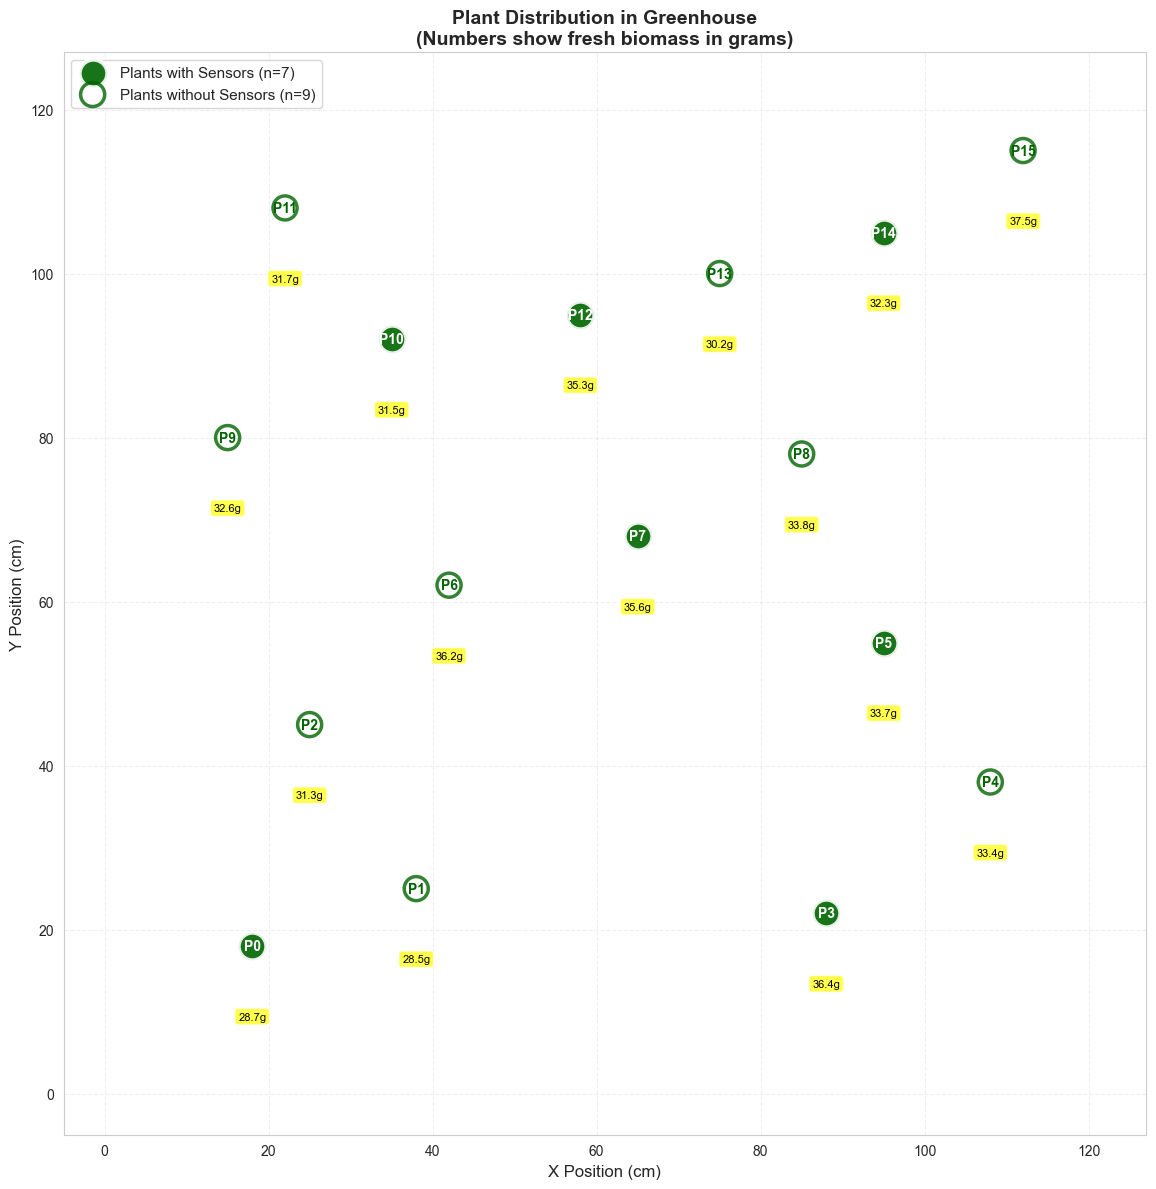


Total plants: 16
Mean biomass: 33.04 g
Biomass range: 28.50 - 37.50 g


In [21]:
# Visualize plant positions
fig, ax = plt.subplots(figsize=(12, 12))

# Plot plants with sensors (filled circles)
measured = plant_mapper.measured_plants
unmeasured = plant_mapper.unmeasured_plants

ax.scatter(measured['x'], measured['y'],
          c='darkgreen', s=400, marker='o',
          edgecolors='white', linewidths=3,
          label=f'Plants with Sensors (n={len(measured)})',
          alpha=0.9, zorder=5)

# Plot plants without sensors (hollow circles)
ax.scatter(unmeasured['x'], unmeasured['y'],
          c='none', s=300, marker='o',
          edgecolors='darkgreen', linewidths=2.5,
          label=f'Plants without Sensors (n={len(unmeasured)})',
          alpha=0.8, zorder=4)

# Add plant IDs and biomass values
for idx, row in plant_mapper.plants.iterrows():
    # Plant ID
    ax.annotate(f"P{int(row['plant_id'])}",
               (row['x'], row['y']),
               color='white' if row['has_sensor'] else 'darkgreen',
               fontsize=10,
               fontweight='bold',
               ha='center',
               va='center',
               zorder=6)
    
    # Biomass value below
    ax.annotate(f"{row['biomass_g']:.1f}g",
               (row['x'], row['y'] - 8),
               color='black',
               fontsize=8,
               ha='center',
               va='top',
               zorder=6,
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.set_xlim(-5, 127)
ax.set_ylim(-5, 127)
ax.set_xlabel('X Position (cm)', fontsize=12)
ax.set_ylabel('Y Position (cm)', fontsize=12)
ax.set_title('Plant Distribution in Greenhouse\n(Numbers show fresh biomass in grams)', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper left', fontsize=11)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

print(f"\nTotal plants: {len(plant_mapper.plants)}")
print(f"Mean biomass: {plant_mapper.plants['biomass_g'].mean():.2f} g")
print(f"Biomass range: {plant_mapper.plants['biomass_g'].min():.2f} - {plant_mapper.plants['biomass_g'].max():.2f} g")

### Generate Biomass Interpolation Map

Now let's create a high-resolution interpolated map of fresh biomass across the entire greenhouse floor.

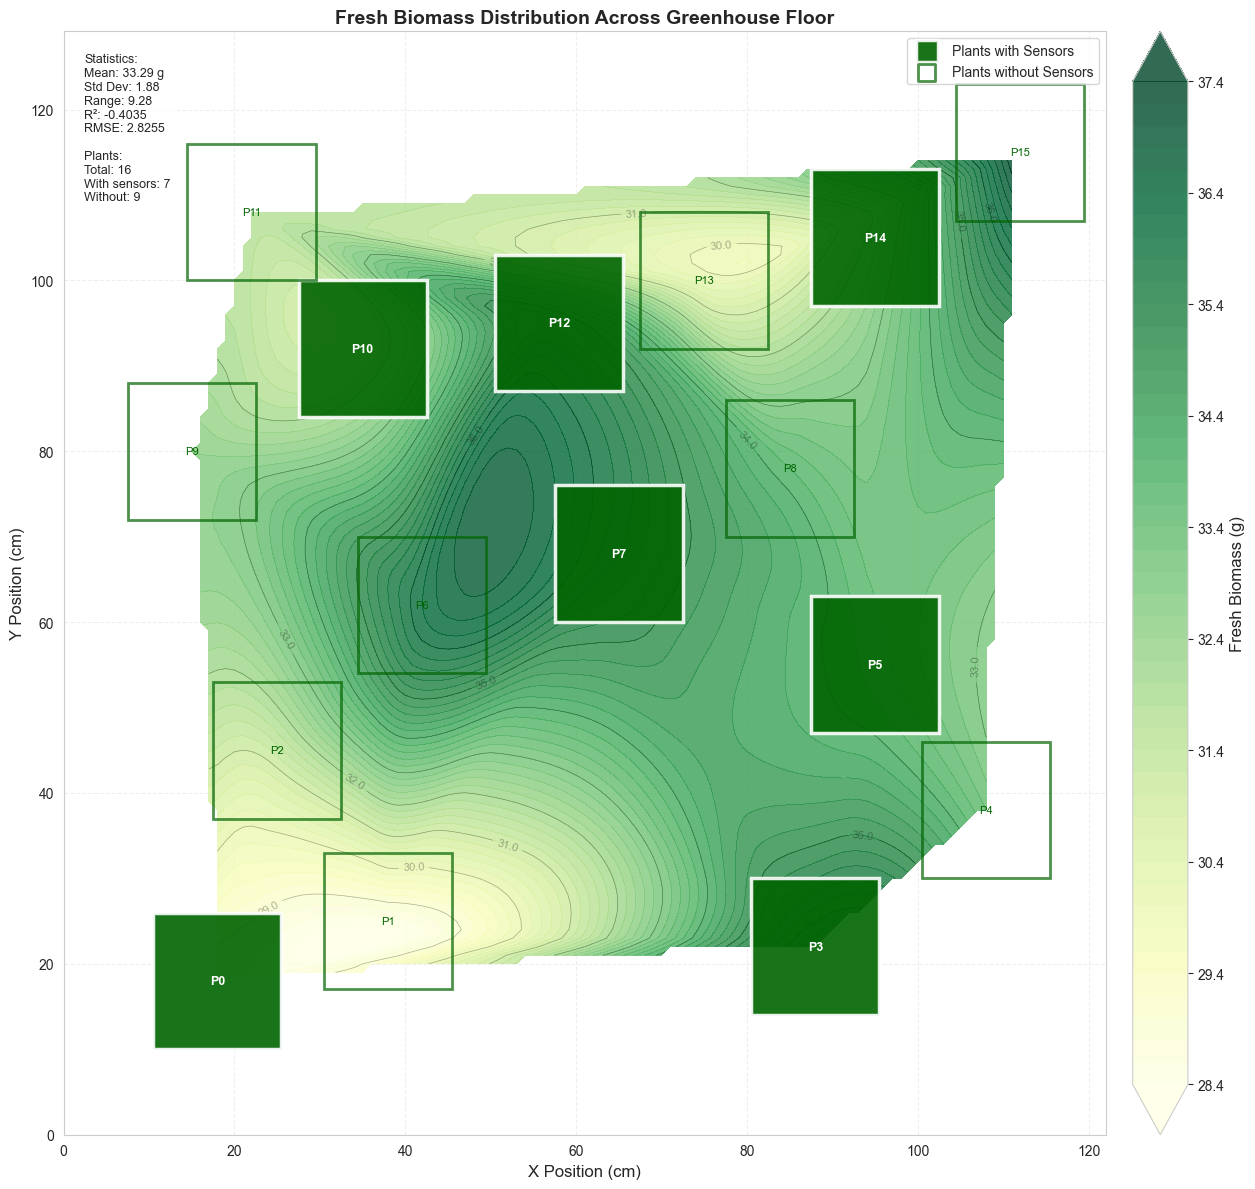


Biomass Interpolation Quality:
R² (interpolation quality): -0.4035
RMSE: 2.83 g
Mean interpolated biomass: 33.29 g
Std Dev: 1.88 g
Range: 9.28 g (28.22 - 37.50 g)


In [22]:
# Create biomass map with plant locations clearly shown
fig_biomass = plant_mapper.plot_plant_map(
    parameter='biomass_g',
    figsize=(14, 12),
    cmap='YlGn',  # Yellow-Green colormap good for biomass
    show_plants=True,
    show_stats=True,
    title='Fresh Biomass Distribution Across Greenhouse Floor'
)
plt.show()

# Get biomass statistics
biomass_stats = plant_mapper.get_statistics('biomass_g')
print("\nBiomass Interpolation Quality:")
print("=" * 60)
print(f"R² (interpolation quality): {biomass_stats['r_squared']:.4f}")
print(f"RMSE: {biomass_stats['rmse']:.2f} g")
print(f"Mean interpolated biomass: {biomass_stats['mean']:.2f} g")
print(f"Std Dev: {biomass_stats['std']:.2f} g")
print(f"Range: {biomass_stats['range']:.2f} g ({biomass_stats['min']:.2f} - {biomass_stats['max']:.2f} g)")
print("=" * 60)

### Combined View: Biomass + Environmental Conditions

For plants with sensors, we can see both biomass distribution and environmental conditions.

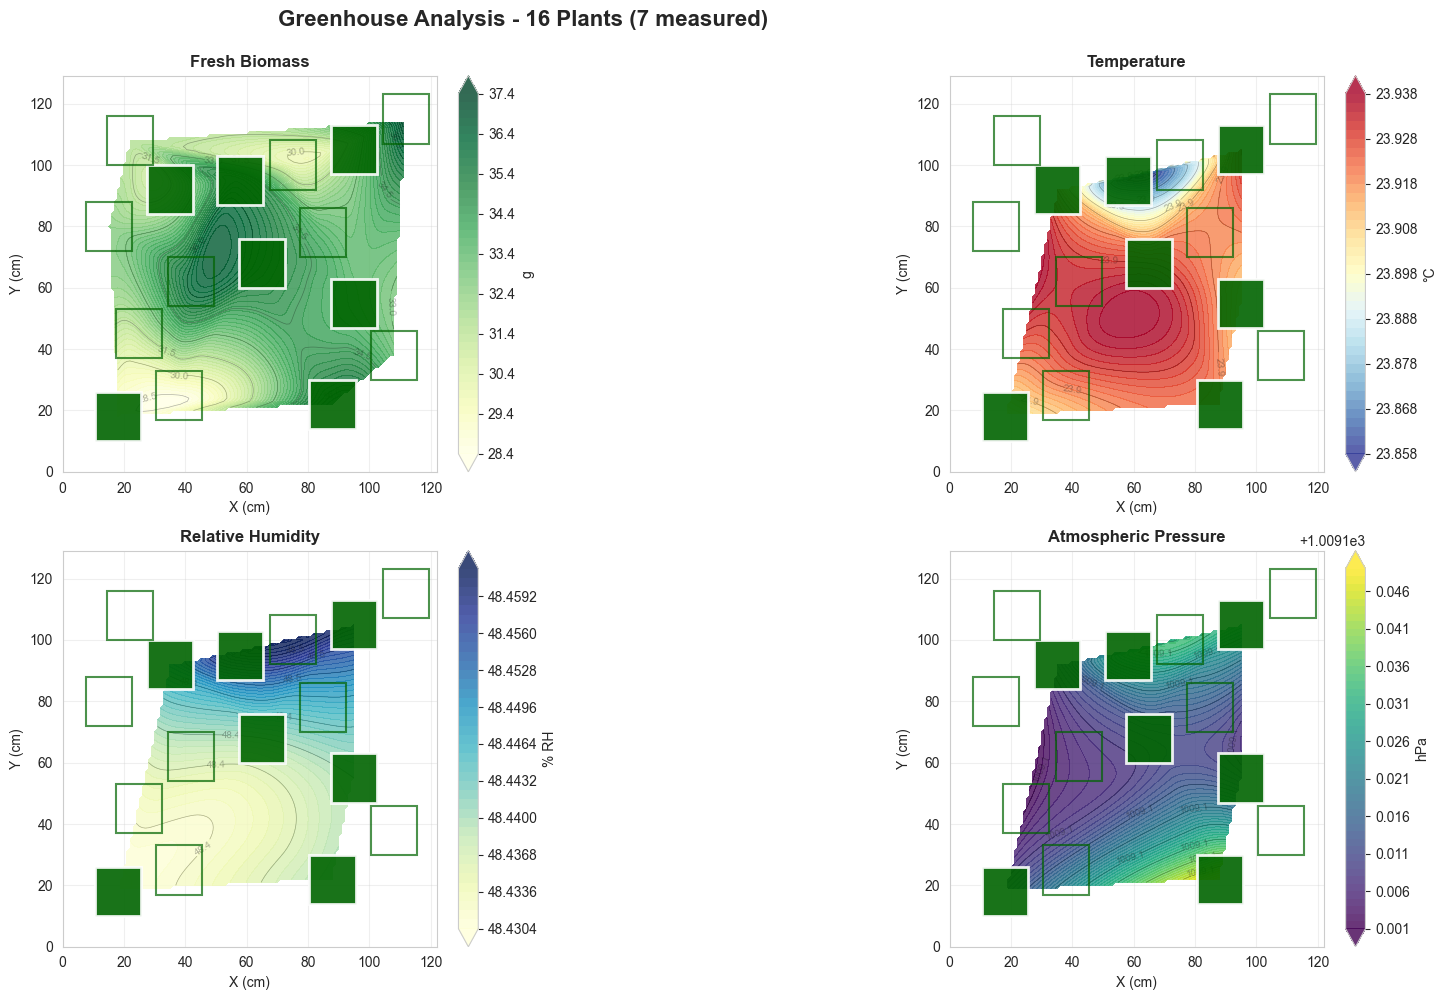


This view shows:
  • Biomass distribution (all 16 plants)
  • Temperature distribution (7 plants with sensors)
  • Humidity distribution (7 plants with sensors)
  • Pressure distribution (7 plants with sensors)

Note the correlation between environmental conditions and biomass!


In [23]:
# Create comprehensive comparison plot
fig_comparison = plant_mapper.plot_plant_comparison(figsize=(20, 10))
plt.show()

print("\nThis view shows:")
print("  • Biomass distribution (all 16 plants)")
print("  • Temperature distribution (7 plants with sensors)")
print("  • Humidity distribution (7 plants with sensors)")
print("  • Pressure distribution (7 plants with sensors)")
print("\nNote the correlation between environmental conditions and biomass!")

### Analyze Biomass vs Environmental Correlations

Let's examine how environmental conditions relate to plant biomass.

In [24]:
# Analyze correlations for plants with sensors
measured_plants_df = plant_mapper.measured_plants.copy()
measured_plants_df = measured_plants_df.drop(columns=['geometry'])

print("Plants with Sensors - Data Summary:")
print("=" * 80)
print(measured_plants_df[['plant_id', 'biomass_g', 'temperature', 'humidity', 'pressure']].to_string())
print("=" * 80)

# Calculate correlations
if len(measured_plants_df) > 2:
    correlations = {
        'Temperature': measured_plants_df[['biomass_g', 'temperature']].corr().iloc[0, 1],
        'Humidity': measured_plants_df[['biomass_g', 'humidity']].corr().iloc[0, 1],
        'Pressure': measured_plants_df[['biomass_g', 'pressure']].corr().iloc[0, 1],
    }
    
    print("\nCorrelation between Biomass and Environmental Factors:")
    print("-" * 60)
    for factor, corr in correlations.items():
        print(f"{factor:15s}: {corr:+.3f}")
    print("-" * 60)
    print("\nNote: Correlation values range from -1 to +1")
    print("  +1 = perfect positive correlation")
    print("  -1 = perfect negative correlation")
    print("   0 = no correlation")

Plants with Sensors - Data Summary:
    plant_id  biomass_g  temperature  humidity  pressure
0          0       28.7        23.90     48.43   1009.11
3          3       36.4        23.92     48.44   1009.15
5          5       33.7        23.91     48.44   1009.11
7          7       35.6        23.93     48.44   1009.11
10        10       31.5        23.92     48.45   1009.11
12        12       35.3        23.86     48.46   1009.13
14        14       32.3        23.93     48.46   1009.13

Correlation between Biomass and Environmental Factors:
------------------------------------------------------------
Temperature    : -0.038
Humidity       : +0.247
Pressure       : +0.543
------------------------------------------------------------

Note: Correlation values range from -1 to +1
  +1 = perfect positive correlation
  -1 = perfect negative correlation
   0 = no correlation


### Summary: Plant Biomass Mapping

**Key Takeaways:**

1. **Mixed Sensor Coverage**: We successfully mapped biomass across 16 plants, even though only 7 have environmental sensors

2. **Interpolation Quality**: The R² value indicates how well the interpolation captures the spatial variation in biomass

3. **Environmental Insights**: For plants with sensors, we can correlate biomass with temperature, humidity, and pressure

4. **Practical Application**: This approach allows you to:
   - Track growth across all plants with fewer sensors
   - Identify spatial patterns in biomass distribution
   - Correlate environmental conditions with plant performance
   - Optimize sensor placement based on interpolation quality

5. **Visualization Benefits**:
   - Clear distinction between measured (filled circles) and unmeasured plants (hollow circles)
   - Biomass values overlaid on each plant
   - Statistical quality metrics for interpolation validation
   - Combined environmental + biomass views for comprehensive analysis
   
**Current Setup**: 16 total plants with only 7 sensors (44% sensor coverage) provides sufficient data for high-quality interpolation across the entire greenhouse floor.